# Exercicis OpenCV

Hem vist com ver funcions bàsiques de OpenCV. Ara ho posarem en pràctica.

La teva tasca es posar en pràctica el que has après en quant a processament d'imatges amb un exemple semblant al que hem vist a classe.

## Exercici 1

Utilitzant OpenCV, carrega la imatge `camp.png`, troba les línies i enmarca-les de color verd.

In [3]:
%pip install matplotlib opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 40.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


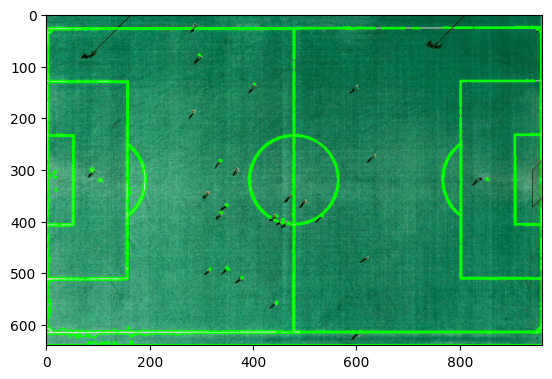

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def process_image(im):
    im_bn = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,160,255,cv2.THRESH_BINARY_INV)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        color = (0, 255, 0)

        cv2.drawContours(im, [contour], 0, color, 2)

    return im

im = cv2.imread("camp.png")
im_proc = process_image(im)
plt.imshow(im_proc)

## Exercici 2

Hem vist com detectar el moviment utilitzant les diferències entre dos _frames_ consecutius. Ara, carrega `vtest.mp4` i utilitza aquest mètode per detectar el moviment en un vídeo i utilitzant la técnica vista en l'exemple del seguiment de línia resalta l'objecte que s'està movent.

Loaded 795 frames


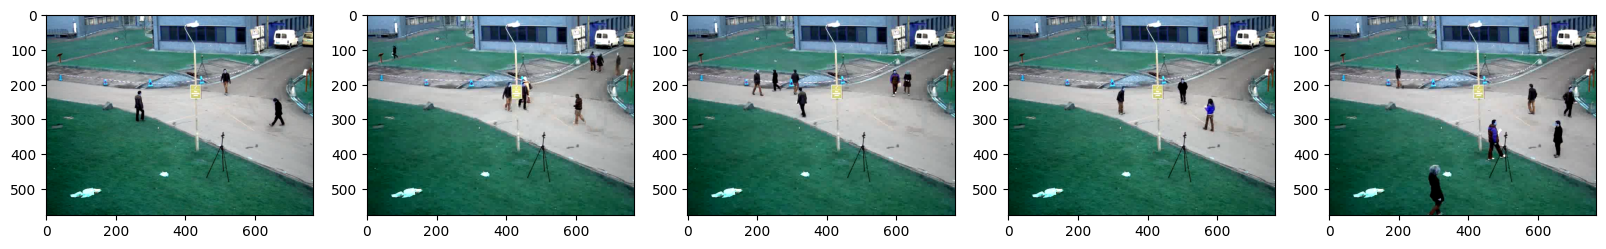

In [32]:
vid = cv2.VideoCapture("vtest.mp4")

frames = []
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)

vid.release()
print(f"Loaded {len(frames)} frames")

# Mostrem els frames de 150 en 150 en una mateixa fila

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(frames[i*150])


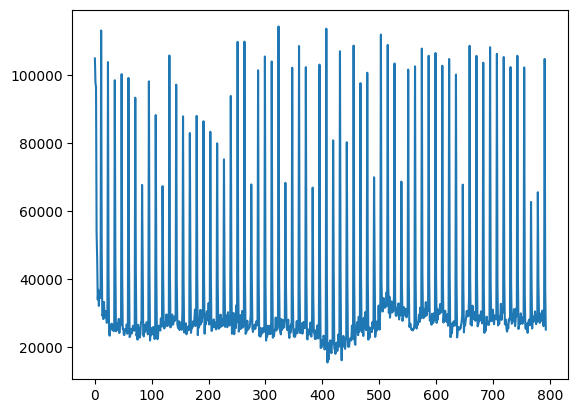

In [8]:
frames_bn = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]
diffs = [(p2 - p1) for p1, p2 in zip(frames_bn[:-1], frames_bn[1:])]
diffs_norms = np.array([np.linalg.norm(x) for x in diffs])

plt.plot(diffs_norms)

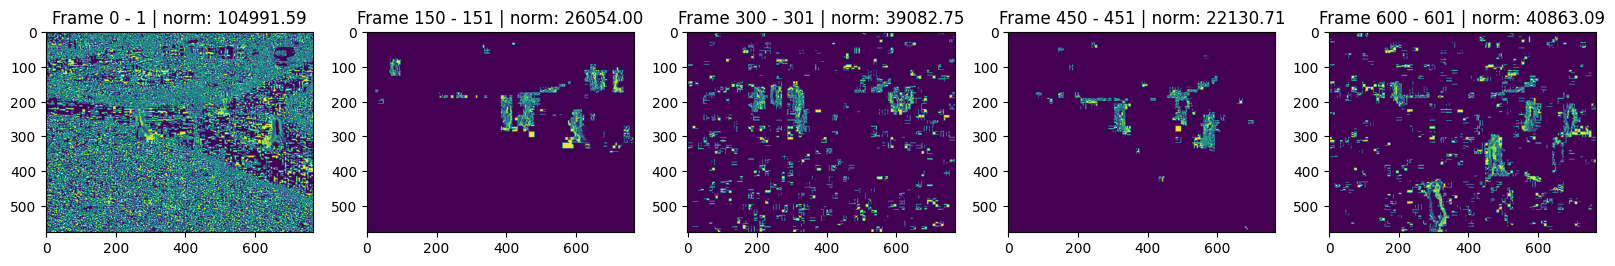

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(diffs[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1} | norm: {diffs_norms[i*150]:.2f}")

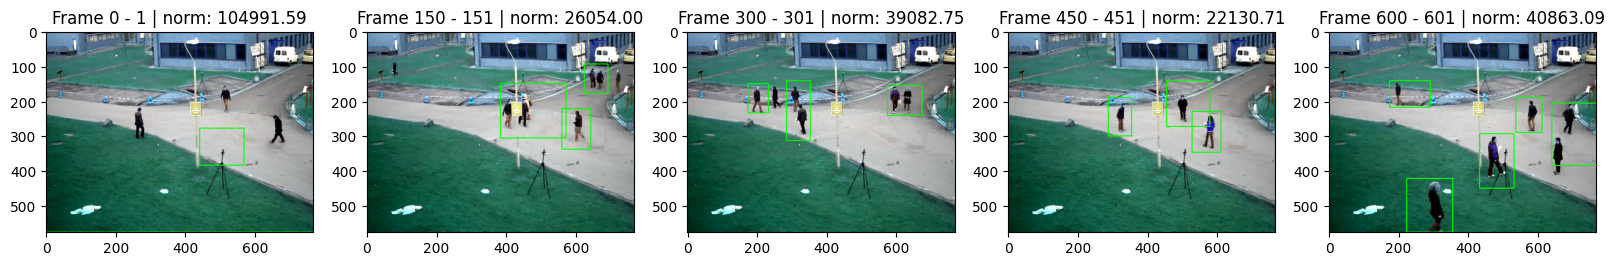

In [33]:
color = (0, 255, 0)

for i, diff in enumerate(diffs):
    # busquem els contorns
    im_blurred = cv2.GaussianBlur(diff, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred, 10, 255, cv2.THRESH_BINARY)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        # filtrem els contorns per area
        area = cv2.contourArea(contour)
        x_min, y_min, w, h = cv2.boundingRect(contour) # BoundingRect ens retorna les coordenades del rectangle que conte el contorn
        x_max = x_min + w
        y_max = y_min + h
        
        # si l'area es mes gran que 2500, el pintem
        if area > 2500:
            # Dibuixem el rectangle
            cv2.rectangle(frames[i], (x_min, y_min), (x_max, y_max), color, 2)

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(frames[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1} | norm: {diffs_norms[i*150]:.2f}")

In [34]:
# Reconstruim el video en format mp4

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('output.mp4', fourcc, 30, (frames[0].shape[1], frames[0].shape[0]))

for frame in frames:
    video.write(frame)

video.release()
print("Video saved")


Video saved


## Exercici 3

Calcula el flux òptic de l'imatge `vtest.mp4` i visualitza'l.

In [57]:
# tornem a llegir el video per mostrar-lo

vid = cv2.VideoCapture("vtest.mp4")

frames_new = []
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frames_new.append(frame)

vid.release()

In [48]:
flows = [cv2.calcOpticalFlowFarneback(frames_bn[i], frames_bn[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(frames_bn)-1)]

flows[0].shape

(576, 768, 2)

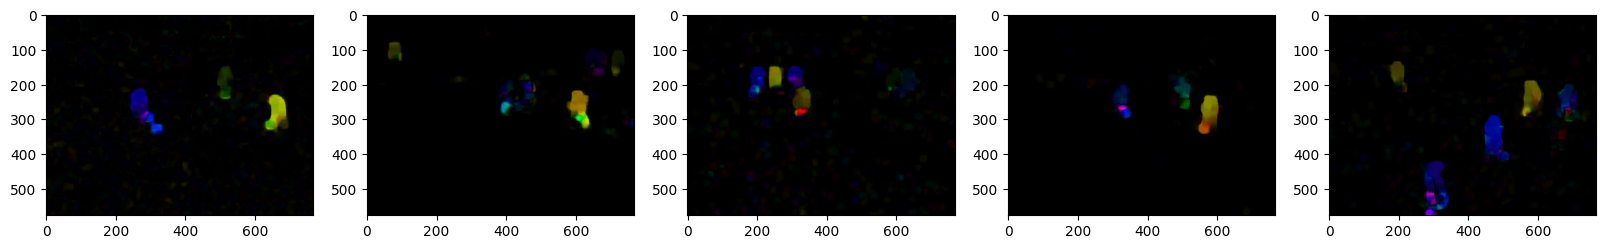

In [49]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)


fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(flow_to_hsv(flows[i*150]))


In [58]:
# Mostrem el video amb els vectors de flow

for i, flow in enumerate(flows):
    for y in range(0, flow.shape[0], 10):
        for x in range(0, flow.shape[1], 10):
            # Dibuixem la linia. La linia va des de la posicio x,y fins a la posicio x+flow[y,x,0], y+flow[y,x,1]
            # Solament dibuixem una linia si la magnitud del flow es mes gran que 1
            if np.linalg.norm(flow[y, x]) > 1:
                cv2.arrowedLine(frames_new[i], (x, y), (x + int(flow[y, x, 0]), y + int(flow[y, x, 1])), (0, 255, 0), 2)


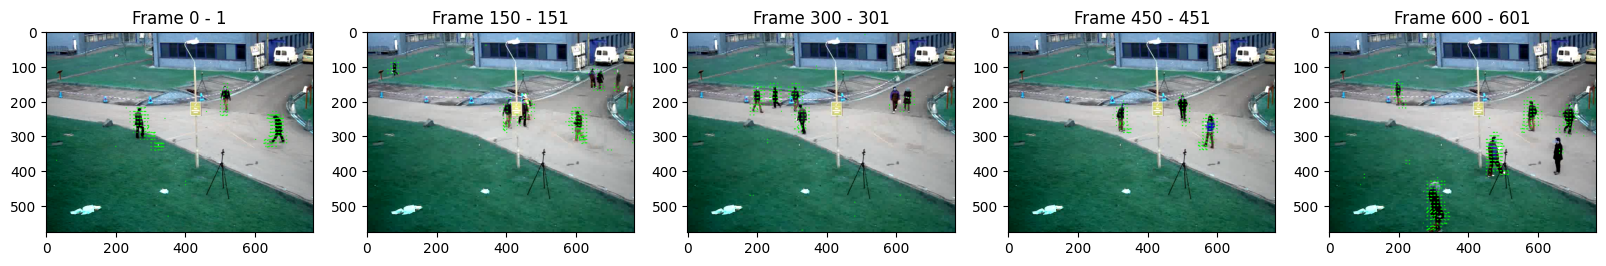

In [59]:
fig, axs = plt.subplots(1, 5, figsize=(20, 50))
for i in range(5):
    axs[i].imshow(frames_new[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1}")